In [1]:
import sys
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/Gaze_project')
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/EvansToolBox/Utils")
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/Gaze_project")
sys.path.insert(0, "C:/Users/evan1/Documents/GitHub/EvansToolBox/Utils")
sys.path.insert(0, "C:/Users/evan1/Documents/GitHub/Gaze_project")
from InputStructures import *
from EyeCatch_implementation import *
from Ground_truth_implementation import *
import json
import numpy as np
import pickle
import os

In [2]:
%load_ext autoreload
%autoreload 1
%aimport EyeCatch_implementation
%aimport Oyekoya_implementation
%aimport Andrist_implementation
%aimport Goude_implementation
%aimport Ground_truth_implementation
%aimport Proposed_model
%aimport Jin_implementation
%aimport Itti_implementation
%aimport Pejsa_implementation
%aimport InputStructures
%aimport Speech_Data_util
%aimport Signal_processing_utils
%aimport Geometry_Util

In [3]:
def output_motion(hk, ek, micro_saccade, outpath):
    blend_weight = []
    for i in range(1, len(hk[0])-1):
        velocity = math.sqrt((hk[0][i][1]-hk[0][i-1][1])**2 + (hk[0][i-1][2]-hk[0][i][2])**2)
        blend_weight.append([hk[0][i][0], 1 - min(1, velocity/0.75)])
    out = {"eye_frames": ek,
            "head_frames": hk,
            "micro_saccade": micro_saccade,
            "other_neck": [],
            "envelope":[], 
            "ambient_neck":[]}
            # "output_times": output_times, 
            # "output_targets": output_targets
    with open(outpath, 'wb') as f:
        pickle.dump(out, f, protocol=2)
    print(outpath)

# Process gaze arr for input gaze:

In [71]:
def dispersion_filtering(x, y, dispersion_threshold = 6, duraiton_threshold=0.2):
    start = 0
    window = []
    if len(x) == 0:
        return [], []
    fps = int(np.round(1/(x[1] - x[0])))
    duration_threshold_frames = np.ceil(duraiton_threshold * fps)
    
    def dispersion(arr):
        # input is a 2d array
        disp = np.max(arr[:, 0]) - np.min(arr[:, 0]) + np.max(arr[:, 1]) - np.min(arr[:, 1])
        return disp

    fixations = []
    fixations_intervals = []
    
    # while there are still points
    while int(start+duration_threshold_frames) < y.shape[0]:
        # initialize a window:
        window = list(range(int(start), int(start+duration_threshold_frames)))
        start = start + duration_threshold_frames
        disp = dispersion(y[window])
        # while the dispersion is less than the threshold
        while disp <= dispersion_threshold:
            if window[-1]+1 < y.shape[0]:
                window.append(window[-1]+1)
            start = start + 1
            if start >= y.shape[0]:
                break
            disp = dispersion(y[window])

        # if the current set of points never fit the duration criteria
        if len(window) <= duration_threshold_frames:
            start = start + 1
        # otherwise note it as fixations
        else:
            centroid = np.mean(y[window], axis=0)
            duration = (window[-1] - window[0]) / fps
            fixations.append([centroid[0], centroid[1], duration])
            fixations_intervals.append([window[0], window[-1]])
    fixations = np.array(fixations)
    return fixations, fixations_intervals

def get_gaze_inputs_naive(eye_traj, head_traj, input_times, input_angles):
    gaze_traj = eye_traj[:, 1:] + head_traj[:, 1:]
    gaze_fixations, gaze_fixations_intervals = dispersion_filtering(eye_traj[:, 0], gaze_traj[:, 1:], 3, duraiton_threshold=0.03)
    gaze_fixations_angles = gaze_fixations[:, 1]
    gaze_fixation_duration = gaze_fixations[:, 2]
    # time arr
    ts = eye_traj[:, 0]
    ts = ts - ts[0]
    input_sequence = []
    for i in range(0, len(gaze_fixations)):
        input_sequence.append([ts[gaze_fixations_intervals[i][0]], gaze_fixations[i, 0]])
    input_sequence = np.array(input_sequence).T
    return input_sequence

def get_gaze_inputs(eye_traj, head_traj, input_times, input_angles):
    gaze_traj = eye_traj[:, 1:] + head_traj[:, 1:]
    gaze_fixations, gaze_fixations_intervals = dispersion_filtering(eye_traj[:, 0], gaze_traj[:, 1:], 3, duraiton_threshold=0.05)
    gaze_fixations_angles = gaze_fixations[:, 1]
    gaze_fixation_duration = gaze_fixations[:, 2]
    # time arr
    ts = eye_traj[:, 0]
    ts = ts - ts[0]
    input_intervals = []
    for i in range(0, len(input_times)-1):
        input_intervals.append([input_times[i], input_times[i+1]])
    input_intervals.append([input_times[-1], input_times[-1]+100])
    # for each intervals of input
    
    for i in range(0, len(input_intervals)):
        # iterate through each gaze interval and find the first time stamp that is within 5 degrees of the input angle
        gaze_fixations_index_in_interval = []
        for j in range(0, len(gaze_fixations_intervals)):
            # it just have to start within the interval
            if ts[gaze_fixations_intervals[j][0]] >= input_intervals[i][0] and ts[gaze_fixations_intervals[j][0]] <= input_intervals[i][1]:
                gaze_fixations_index_in_interval.append(gaze_fixations_intervals[j])
        interval_to_look = [gaze_fixations_index_in_interval[0][0], gaze_fixations_index_in_interval[-1][1]]
        starting_index = -1
        for j in range(interval_to_look[0], interval_to_look[1]):
            if abs(gaze_traj[j, 1] - input_angles[i]) < 1:
                starting_index = j
                break    
        if starting_index == -1:
            for j in range(interval_to_look[0], interval_to_look[1]):
                if abs(gaze_traj[j, 1] - input_angles[i]) < 5:
                    starting_index = j
                    break
        print(interval_to_look, starting_index)
        # plot the trajectory and the starting point
        # plt.plot(ts[interval_to_look[0]:interval_to_look[1]], gaze_traj[interval_to_look[0]:interval_to_look[1], 1])
        plt.plot(ts[interval_to_look[0]:interval_to_look[1]], head_traj[interval_to_look[0]:interval_to_look[1], 1])
        plt.plot(ts[starting_index], head_traj[starting_index, 1], 'r*')
        plt.show()
        
            

    
    for i in range(0, len(input_intervals)):
        continue
        # find the gaze fixations that are in the interval
        gaze_fixations_index_in_interval = []
        for j in range(0, len(gaze_fixations_intervals)):
            # it just have to start within the interval
            if ts[gaze_fixations_intervals[j][0]] >= input_intervals[i][0] and ts[gaze_fixations_intervals[j][0]] <= input_intervals[i][1]:
                gaze_fixations_index_in_interval.append(j)
        # this is the interval of interest
        interval_of_interest = [gaze_fixations_intervals[gaze_fixations_index_in_interval[0]][0], gaze_fixations_intervals[gaze_fixations_index_in_interval[-1]][1]]
        fixations_angles_in_interval = gaze_fixations[gaze_fixations_index_in_interval, 0]
        # find the first angle within 5 degrees of the input angle in this interval
        index_of_first_angle_within_5_degrees = -1
        for j in range(0, len(fixations_angles_in_interval)):
            if abs(fixations_angles_in_interval[j] - input_angles[i]) < 5:
                index_of_first_angle_within_5_degrees = gaze_fixations_index_in_interval[j]
                break
        if index_of_first_angle_within_5_degrees == -1:
            for j in range(0, len(fixations_angles_in_interval)):
                if abs(fixations_angles_in_interval[j] - input_angles[i]) < 10:
                    index_of_first_angle_within_5_degrees = gaze_fixations_index_in_interval[j]
                    break
        print(input_angles[i])
        # plot the gaze trajectory
        plt.plot(ts[interval_of_interest[0]:interval_of_interest[1]], gaze_traj[interval_of_interest[0]:interval_of_interest[1], 1])
        # plot the gaze fixations from the first point to the point that is within 5 degrees of the input angle till the end of the gaze fixations
        plt.plot(ts[gaze_fixations_intervals[index_of_first_angle_within_5_degrees][0]:gaze_fixations_intervals[index_of_first_angle_within_5_degrees][1]], gaze_traj[gaze_fixations_intervals[index_of_first_angle_within_5_degrees][0]:gaze_fixations_intervals[index_of_first_angle_within_5_degrees][1], 1], 'r')
        plt.show()

# List of Inputs and Scenes

In [5]:
class InternalModelFromCapture:
    def __init__(self, input_json, gaze_arr = None):
        # input json is generated from the quest pro capture from experimentation/Analyze_trajectory_research_paper.py\
        self.input_json = input_json
        self.gaze_arr = gaze_arr
    def estimate_target_pose(self, index):
        if self.gaze_arr is not None:
            angle = self.gaze_arr[index]
        else:
            angle = self.input_json["input_target_angle"][index]
        pos = directions_from_rotation_angles(np.array([[angle, 0]]), 100)[0]
        return pos
    def get_base_pose(self):
        return np.array([0, 0, 100])

In [6]:
drive = "F:/"
# drive = "E:/"
input_json_0 = json.load(open(os.path.join(*[drive, "MASC/EYE_IK/ground_truth/Experiment_2_onward_condition_pilot.json"])))
print(input_json_0.keys())

internal_model_0 = InternalModelFromCapture(input_json_0)
sequence_0 = []
for i in range(0, len(input_json_0["input_target_angle"])):
    sequence_0.append([input_json_0["input_target_times"][i], input_json_0["input_target_angle"][i]])

dict_keys(['head_trajectory', 'eye_trajectory', 'target_trajectory', 'input_target_times', 'input_target_angle'])


# Select the Deesired set of inputs

In [69]:
OUTPUT_ROOT = "C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data"
# OUTPUT_ROOT = "C:/Users/evan1/OneDrive/Documents/GitHub/EyeIK/animation_data"

input_json = input_json_0
sequence = sequence_0
input_sequence = get_gaze_inputs_naive(np.array(input_json["eye_trajectory"]), np.array(input_json["head_trajectory"]), input_json["input_target_times"], input_json["input_target_angle"])
input_sequence = np.array(sequence).T
internal_model = InternalModelFromCapture(input_json, gaze_arr = input_sequence[1].copy())
for i in range(0, input_sequence.shape[1]):
    input_sequence[1][i] = int(i)
gaze_positions = []
for i in range(0, input_sequence.shape[1]):
    gaze_positions.append(internal_model.estimate_target_pose(i))

# Visualizing the output arrays in Maya

In [63]:
def compare_kf_plot(ek1, ek2, hk1, hk2):
    # index 0 = time
    # index 1 = sideways
    hk1 = np.array(hk1)[0]
    hk2 = np.array(hk2)[0]
    # plt.plot(ek2[:, 0], ek2[:, 1], 'r')
    plt.plot(hk2[:, 0], hk2[:, 1], 'b')
    plt.plot(hk1[:, 0], hk1[:, 1], 'g')
    plt.show()  

yeet
C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data\GT.pkl


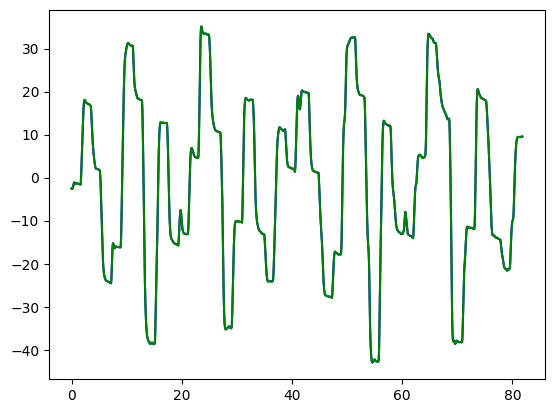

In [74]:
from Ground_truth_implementation import *

saccade_generator = Ground_truth_SacccadeGenerator(input_json=input_json)
gt_ek, gt_hk, gt_micro_saccade = saccade_generator.compute()
output_motion(gt_hk, gt_ek, gt_micro_saccade, os.path.join(OUTPUT_ROOT, "GT.pkl"))
gt_angles = np.array(gt_hk[0])[:, 1]
gt_times = np.array(gt_hk[0])[:, 0]
gt_angles_interp = interp1d(gt_times, gt_angles, axis=0, fill_value="extrapolate")
compare_kf_plot(gt_ek, gt_ek, gt_hk, gt_hk)


C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data\EyeCatch.pkl


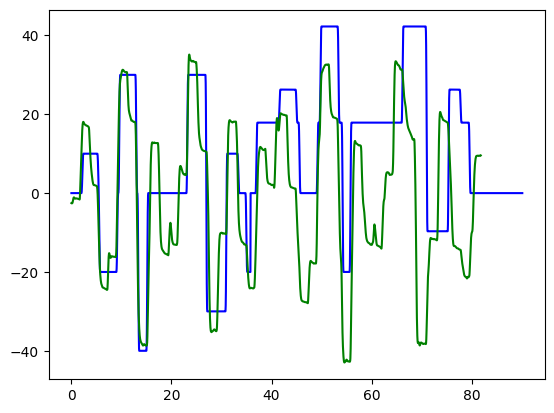

In [66]:
from EyeCatch_implementation import *
# get target positions from the scene:
saccade_generator = EyeCatch_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
ek, hk, micro_saccade = saccade_generator.compute()
output_motion(hk, ek, micro_saccade, os.path.join(OUTPUT_ROOT, "EyeCatch.pkl"))
compare_kf_plot(gt_ek, ek, gt_hk, hk)

C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data\Oyekoya.pkl


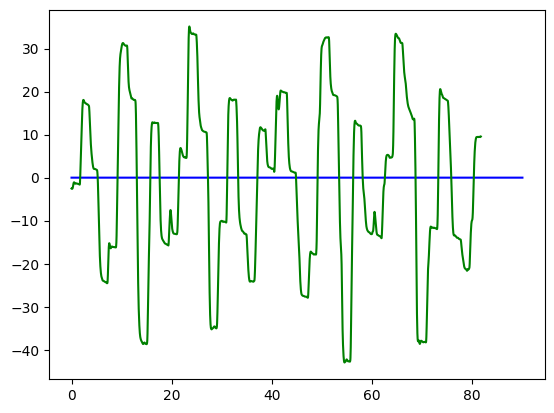

In [16]:

from Oyekoya_implementation import *
# get target positions from the scene:
saccade_generator = Oyekoya_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
ek, hk, micro_saccade = saccade_generator.compute()    
output_motion(hk, ek, micro_saccade, os.path.join(OUTPUT_ROOT, "Oyekoya.pkl"))
compare_kf_plot(gt_ek, ek, gt_hk, hk)

C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data\Andrist.pkl


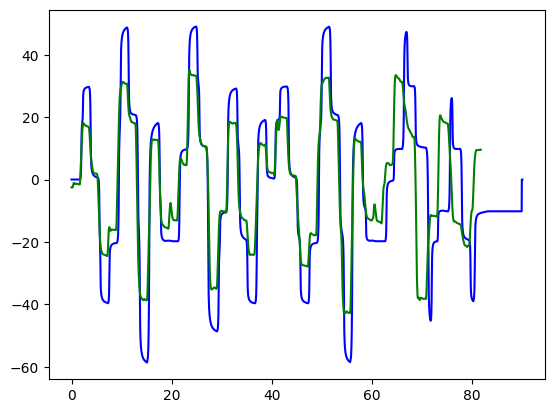

In [17]:
from Andrist_implementation import *
# get target positions from the scene:
saccade_generator = Andrist_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model, 1)
ek, hk, micro_saccade = saccade_generator.compute()    
output_motion(hk, ek, micro_saccade, os.path.join(OUTPUT_ROOT, "Andrist.pkl"))
compare_kf_plot(gt_ek, ek, gt_hk, hk)

C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data\Goude.pkl


C:\Users/evansamaa/Documents/GitHub/EvansToolBox/Utils\Geometry_Util.py:47: RuntimeWarning: invalid value encountered in divide
  out = arr / mag


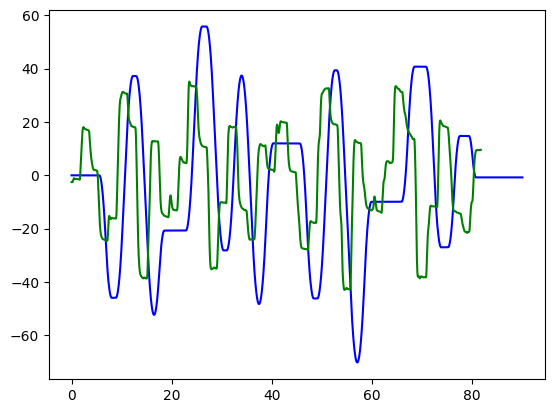

In [18]:
from Goude_implementation import *
# get target positions from the scene:

saccade_generator = Goude_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
ek, hk, micro_saccade = saccade_generator.compute()
output_motion(hk, ek, micro_saccade, os.path.join(OUTPUT_ROOT, "Goude.pkl"))
compare_kf_plot(gt_ek, ek, gt_hk, hk)


c:\Users\evansamaa\anaconda3\envs\JaliGaze\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.1 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data\Jin.pkl


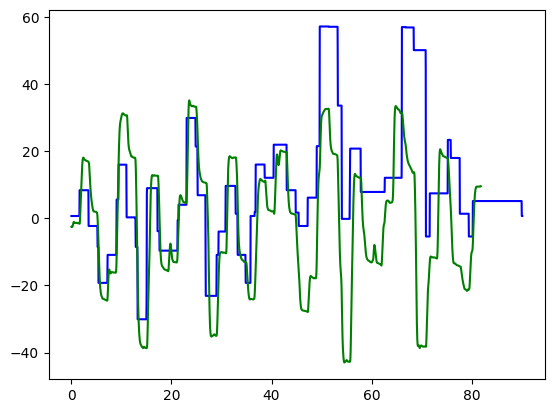

In [19]:

from Jin_implementation import *
# get target positions from the scene:
saccade_generator = Jin_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
ek, hk, micro_saccade = saccade_generator.compute()
output_motion(hk, ek, micro_saccade, os.path.join(OUTPUT_ROOT, "Jin.pkl"))
compare_kf_plot(gt_ek, ek, gt_hk, hk)



C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data\Itti.pkl


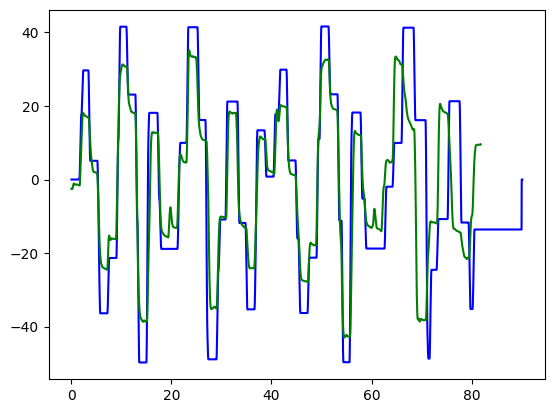

In [20]:

from Itti_implementation import *
# get target positions from the scene:
saccade_generator = Itti_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
ek, hk, micro_saccade = saccade_generator.compute()
output_motion(hk, ek, micro_saccade, os.path.join(OUTPUT_ROOT, "Itti.pkl"))
compare_kf_plot(gt_ek, ek, gt_hk, hk)

C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data\Pejsa.pkl


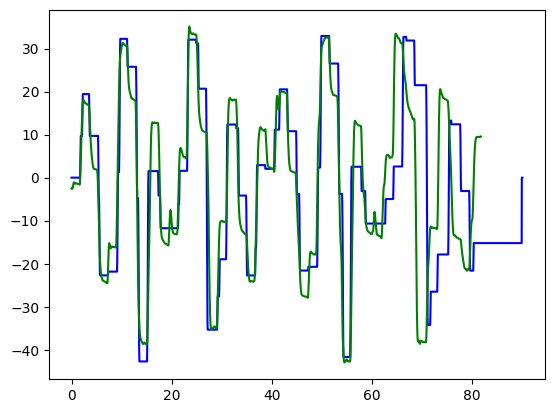

In [31]:

from Pejsa_implementation import *
# get target positions from the scene:
saccade_generator = Pejsa_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model, 0.5)
ek, hk, micro_saccade = saccade_generator.compute()
output_motion(hk, ek, micro_saccade, os.path.join(OUTPUT_ROOT, "Pejsa.pkl"))
compare_kf_plot(gt_ek, ek, gt_hk, hk)


C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data\Proposed.pkl


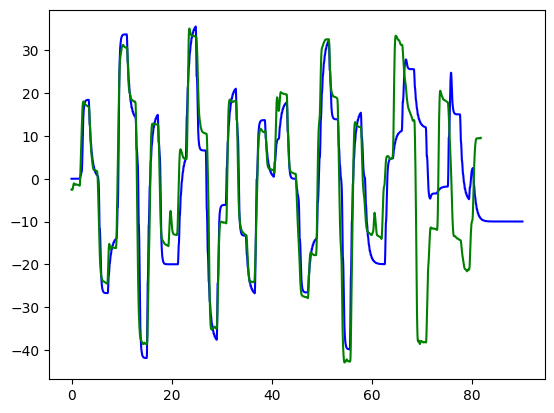

In [22]:
from Proposed_model import *
# get target positions from the scene:
saccade_generator = Proposed_saccade_generator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
ek, hk, micro_saccade = saccade_generator.compute()
output_motion(hk, ek, micro_saccade, os.path.join(OUTPUT_ROOT, "Proposed.pkl"))
compare_kf_plot(gt_ek, ek, gt_hk, hk)

C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data\Proposed_graph1.pkl


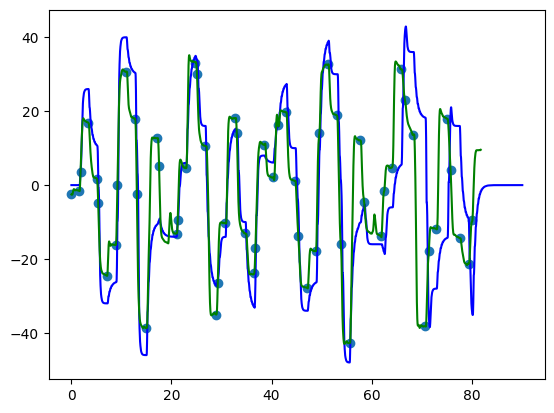

In [76]:
import networkx as nx
from Proposed_model import *

def dwell_factored_eye_strain_function(dwell_time, angle_j, angle0, angle1):
    # vanilla
    # dwell_time_factor1 = dwell_time
    # dwell_time_factor0 = np.maximum(1.5 - dwell_time, 0)
    
    # probably better?
    dwell_time_factor1 = np.maximum(0.0001, 1.5-np.log(dwell_time + 1)) 
    dwell_time_factor0 = np.log(dwell_time + 1)
    return dwell_time_factor1 * np.square(np.linalg.norm(angle_j - angle1)) + dwell_time_factor0 * np.square(np.linalg.norm(angle_j - angle0))
def head_moving_cost_function(prev, current, laziness=0.3):
    # cost is the distance the the head has to move
    cost = laziness * np.linalg.norm(prev - current) 
    # but this cost is lowered in the direction of the midline
    if prev * current < 0:
        cost *= 0.5
    return 0*cost
def create_graph(self):
    gaze_trajectory_1 = self.input_gaze_pos_as_angles_per_frame
    gaze_trajectory_0 = self.input_gaze_pos_as_angles_per_frame_smoothed
    gaze_positions = self.gaze_pos_as_angles
    gaze_intervals = self.target_gaze_intervals_time
    graphs = []
    for dimension in range(0, 2):
        if dimension == 0:
            range_limit = 60
        else:
            range_limit = 30
        G = nx.DiGraph()
        list_plot = []
        for i in range(0, gaze_positions.shape[0]):
            t_index = int(np.ceil(gaze_intervals[i][0]/self.simulation_dt))
            t_index = min(t_index, gaze_trajectory_0.shape[0]-1)
            target_angle_0 = gaze_trajectory_0[t_index, dimension]
            target_angle_1 = gaze_trajectory_1[t_index, dimension]
            list_plot.append(target_angle_1)
            dwell_time = gaze_intervals[i][1] - gaze_intervals[i][0]
            for j in range(-range_limit, range_limit, 2):
                G.add_node((i, j), value=dwell_factored_eye_strain_function(dwell_time, j, target_angle_0, target_angle_1))
                if i > 0:
                    for j_prev in range(-range_limit, range_limit, 2):
                        G.add_edge((i-1, j_prev), (i, j), weight=head_moving_cost_function(j_prev, j))
        G.add_node((gaze_positions.shape[0], 0), value=0)
        for j_prev in range(-range_limit, range_limit, 2):
            G.add_edge((gaze_positions.shape[0]-1, j_prev), (gaze_positions.shape[0], 0), weight=head_moving_cost_function(j_prev, j))
        graphs.append(G)
    return graphs
def optimize_head_pos(self):
    G_0, G_1 = create_graph(self)
    def combined_weight0(u, v, d):
        return G_0.nodes[v]['value'] + d['weight']
    def combined_weight1(u, v, d):
        return G_1.nodes[v]['value'] + d['weight']
    path_0 = nx.dijkstra_path(G_0, (0, 0), (saccade_generator.gaze_pos_as_angles.shape[0], 0), combined_weight0)
    path_0 = np.array(path_0)[:, 1:2]
    path_1 = nx.dijkstra_path(G_1, (0, 0), (saccade_generator.gaze_pos_as_angles.shape[0], 0), combined_weight1)
    path_1 = np.array(path_1)[:, 1:2]
    head_angles = np.concatenate([path_0, path_1], axis=1)
    head_pos = directions_from_rotation_angles(head_angles, 100)
    return head_angles, head_pos 

saccade_generator = Proposed_saccade_generator_with_graph(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
ek_propsed, hk_proposed, micro_saccade_proposed = saccade_generator.compute(optimize_head_pos(saccade_generator)[1])
output_motion(hk_proposed, ek_propsed, micro_saccade_proposed, os.path.join(OUTPUT_ROOT, "Proposed_graph1.pkl"))
compare_kf_plot(gt_ek, ek_propsed, gt_hk, hk_proposed)
